In [1]:
# import modules 
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D


Constructing face 1
Set 1 of bounding lines
Constructing face 2
Set 1 of bounding lines
Constructing face 3
Set 1 of bounding lines
Constructing face 4
Set 1 of bounding lines
Constructing face 5
Set 1 of bounding lines
Constructing face 6
Set 1 of bounding lines
Constructing face 7
Set 1 of bounding lines
Constructing face 8
Set 1 of bounding lines
Testing planes of distance index 2
jj =  9
jj =  10
jj =  11
jj =  12
jj =  13
jj =  14
Testing planes of distance index 3


C:\Users\Wiley Dunlap-Shohl\Documents\Anaconda3\lib\site-packages\ipykernel_launcher.py:500: RuntimeWarning: divide by zero encountered in double_scalars


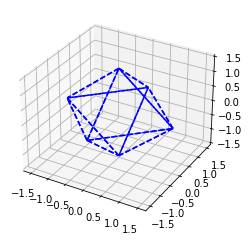

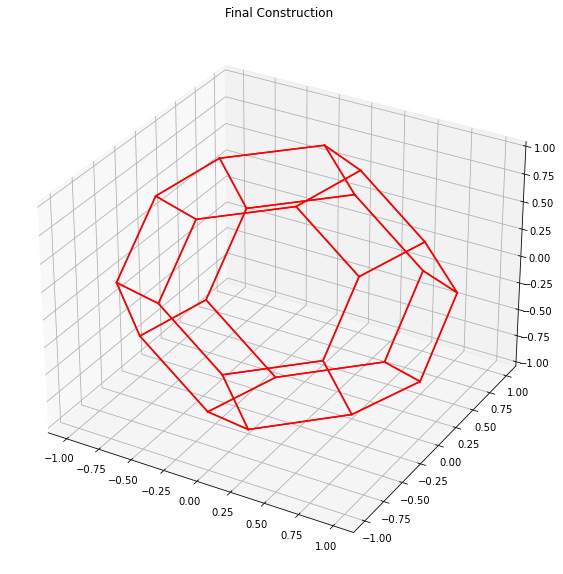

In [149]:
# parameters
n_max = 3 # how many points in k-space to investigate from the origin 
n_zones = 1 # how many zones to plot
make_plot = True
eps_roundoff = 1e-10 # round-off error margin

debug = True

# define the lattice vectors in real space
xhat = np.array([1,0,0])
yhat = np.array([0,1,0])
zhat = np.array([0,0,1])

# simple cubic
a1 = xhat
a2 = yhat
a3 = zhat

# face-centered cubic
a1 = 0.5*(yhat + zhat)
a2 = 0.5*(zhat + xhat)
a3 = 0.5*(xhat + yhat)

# body-centered cubic
# a1 = 0.5*(-xhat + yhat + zhat)
# a2 = 0.5*(xhat - yhat + zhat)
# a3 = 0.5*(xhat + yhat - zhat)

# calculate the reciprocal vectors

trip_prod = np.dot(a1,np.cross(a2,a3))

b1 = (1/trip_prod)*np.cross(a2,a3)
b2 = (1/trip_prod)*np.cross(a3,a1)
b3 = (1/trip_prod)*np.cross(a1,a2)

# calculate K-points in the reciprocal lattice

# initialize list of "quantum numbers"
n1s = []
n2s = []
n3s = []
Ks = []
K_mags = []

# loop over indices to populate "quantum numbers" and K-vectors
for n1 in range(-n_max,n_max,1):
    for n2 in range(-n_max,n_max,1):
        for n3 in range(-n_max,n_max,1):
            n1s.append(n1)
            n2s.append(n2)
            n3s.append(n3)
            Ks.append(n1*b1 + n2*b2 + n3*b3)
            K_mags.append(np.linalg.norm(n1*b1 + n2*b2 + n3*b3))
            
K_DF = pd.DataFrame({'K':Ks,
                     'n1':n1s,
                     'n2':n2s,
                     'n3':n3s,
                     '|K|':K_mags,
                    })

# assign "distances" from the origin
K_DF['n^2'] = K_DF['n1']**2 + K_DF['n2']**2 + K_DF['n3']**2

# sort the entries according to distance
K_DF = K_DF.sort_values('|K|',ignore_index=True)

# rank the planes by distance
ranks = []
rank = 0
for ii in range(len(K_DF['|K|'].values)):
    if ii == 0:
        ranks.append(rank)
        continue
    elif np.abs(K_DF['|K|'].values[ii] - K_DF['|K|'].values[ii-1]) > eps_roundoff:
        rank += 1
    ranks.append(rank)
K_DF['Distance Index'] = ranks

# we set them all up
# this is the exciting bit
# now loop over zones
for zonem1 in range(n_zones):
    zone = zonem1 + 1
    
    # planes on zone edges
    # these ones are important, and
    # the others ignored
    
    # zone 1 is unique
    # there is no plane set below
    # just take the high ones
    if zone == 1:
        K_red = K_DF[K_DF['Distance Index'] == zone]
    else:
        # look above - high K points
        # take these from the master sheet
        # reject the others
        K_hi = K_DF[K_DF['Distance Index'] == zone]
        # do it over again
        # but now in opposite world
        # the low points are high
        K_lo = K_DF[K_DF['Distance Index'] == zonem1]
        
        K_red = pd.concat([K_lo,K_hi],ignore_index=True)
        
    # now determine which pairs of planes intersect
    
    # set up list of faces that define the first Brillouin zone
    BZ1_faces = []
    
    if make_plot:
        z_fig = plt.figure()
        ax = z_fig.add_subplot(projection='3d')
    
    # scan over each K-point, corresponding to a face in the cell
    idx_list = list(K_red.index)
    for ii in idx_list:
        
        if debug:
            print('Constructing face',ii)
        
        # initialize the dictionary and variables relating to face definition:
        
        face = {} # initialize an empty dictionary
        face['K'] = K_red['K'][ii] # assign the corresponding K point
        bounding_lines = [] # initialize a list of parameters to find the lines bounding that face
        edges = [] # initialize a list of vector pairs to describe edges
        
        # generate a list of indices of all other planes
        red_idx_list = [item for item in idx_list if item != ii]
        
        # scan over all other K-planes of equivalent distance to find which ones intersect and if so,
        # define the line of their intersection
        for jj in red_idx_list:
            
            # if the planes are not parallel:
            if np.linalg.norm(np.cross(K_red['K'][ii],K_red['K'][jj])) != 0:
                
                # find the corresponding line of intersection between the planes
                K1 = K_red['K'][ii] # K-point 1
                K2 = K_red['K'][jj] # K-point 2
                v = np.cross(K1,K2) # "velocity" vector lying along the line
                
                # any point on the line will do, but for simplicity we choose the point closest to the origin,
                # so p (dot) v = 0. We can set up a matrix of coefficients and solve by inverting:
                K_mat = np.array([K1,K2,v])
                b = np.array([0.5*np.dot(K1,K1),0.5*np.dot(K2,K2),0])
                p = np.matmul(np.linalg.inv(K_mat),b)
                
                # keep track of the parameters defining the bounding lines
                bounding_lines.append([p,v])
        
        # we now have a set of bounding lines, but only a subset will actually define the edges of the face.
        # We will rank them by distance to the point at which the plane is intersected by the line along K,
        # defined by the vector 1/2 K.
        
        # convert the list to a dataframe
        BL_dict = {}
        BL_dict['Line Parameters'] = bounding_lines
        BL_DF = pd.DataFrame(BL_dict)
        K_distances = []
        
        # assign minimum distances as distance between 1/2 K and line definition point p... 
        for params in bounding_lines:
            K_distances.append(np.linalg.norm(params[0] - 0.5*K_red['K'][ii]))
        BL_DF['1/2 K Distance'] = K_distances
        # ...then sort in ascending order 
        BL_DF = BL_DF.sort_values('1/2 K Distance',ignore_index=True)
        
        # rank the lines by distance
        l_ranks = []
        for jj in range(len(BL_DF['1/2 K Distance'].values)):
            # first iteration: set rank = 1
            if jj == 0:
                l_rank = 1
            # successive iterations: if distance changes beyond roundoff error, increment rank
            elif np.abs(BL_DF['1/2 K Distance'].values[jj] - BL_DF['1/2 K Distance'].values[jj-1]) > eps_roundoff:
                l_rank += 1
            l_ranks.append(l_rank)
        BL_DF['Distance Index'] = l_ranks
        
        jj = 1
        chop = True
        
        # now iterate over each block of bounding lines, ranked by distance
        while chop:
            
            # pare down the bounding lines dataframe to only include lines of the selected distance
            BL_red = BL_DF[BL_DF['Distance Index'] == jj]
            BLs = BL_red['Line Parameters'].values # rename for brevity
            
            # on the first pass, calculate the initial face
            if jj == 1:
                
                if debug:
                    print('Set',jj,'of bounding lines')
                
                trial_edges = [] # initialize empty list of edges
                
                # now scan over all bounding lines in the subset
                for kk, params in enumerate(BLs):

                    edge = [] # initialize the pair of endpoints defining an edge

                    # generate a list of all the other lines in the subset
                    red_lines = list(BLs).copy()
                    red_lines.pop(kk)
            
                    # for each other line in the face:
                    for params2 in red_lines:
                        # extract parameters corresponding to the two lines
                        p1 = params[0]
                        v1 = params[1]
                        p2 = params2[0]
                        v2 = params2[1]

                        # reject parallel line pairs
                        if np.linalg.norm(np.cross(v1,v2)) == 0:
                            continue
                        else:    
                            # solve for the parameters (t-values) yielding the minimum distance between lines
                            V_mat = np.array([[np.dot(v1,v1), -np.dot(v1,v2)],
                                              [-np.dot(v1,v2), np.dot(v2,v2)],
                                             ])
                            q = np.array([-np.dot(v1,p1-p2),np.dot(v2,p1-p2)])
                            t = np.matmul(np.linalg.inv(V_mat),q)
                            # calculate the displacement vector between them
                            line_disp = p1 - p2 + t[0]*v1 - t[1]*v2

                            # if the lines intersect, one of the endpoints has been found:
                            if np.linalg.norm(line_disp) < eps_roundoff:
                                edge.append(p1 + t[0]*v1)
                    
                    trial_edges.append(edge) # after looking at all other bounding lines, keep track of the edges

                for edge in trial_edges:
                    if make_plot:
                        t = np.linspace(0,1,num=2)

                        x = edge[0][0] + t*(edge[1][0] - edge[0][0])
                        y = edge[0][1] + t*(edge[1][1] - edge[0][1])
                        z = edge[0][2] + t*(edge[1][2] - edge[0][2])

                        ax.plot(x,y,z,'b--')
                        
#                 if debug:
#                     chop = False
                    
                jj += 1
            
            # on successively distant sets of bounding lines, try to truncate the face
            else:
                
                # first, apply the "vertex test" to determine whether the new set of edges even pass close enough
                # to the 1/2 K point to truncate the face
                vert_dist = 0 # initialize max vertex distance
                for edge in trial_edges: # scan over all points in the trial edge:
                    for point in edge:
                        # if we find a more distant vertex, record the distance
                        if np.linalg.norm(point - 0.5*K_red['K'][ii]) > vert_dist:
                            vert_dist = np.linalg.norm(point - 0.5*K_red['K'][ii])
                            
                # if truncation is not possible, raise the stop condition
                if vert_dist - BL_red['1/2 K Distance'].iloc[0] < eps_roundoff:
                    
                    edges = trial_edges
                    chop = False
                    
                
                # if we keep truncating:
                else:    
                    # initialize variables to keep track of edges of the new face
                    new_edge = [] # generated by truncation
                    E_near = [] # on the near side of the K-point, retained unchanged
                    E_cut = [] # truncated edges
                    edges = trial_edges.copy()
                    
                    # scan over bounding lines
                    for kk, params in enumerate(BLs):
                        
                        # get parameters defining the bounding line
                        p = params[0]
                        v = params[1]
                        
                        # scan over trial edges
                        for edge in edges:
                            
                            # get parameters defining endpoints of the edge
                            p1 = edge[0]
                            p2 = edge[1]
                            
                            # calculate the parameter defining how far along the edge line the bounding
                            # line strikes it
                            s = np.dot(p-p1,K_red['K'][ii]) / np.dot(p2-p1,K_red['K'][ii])

                            # distance along the line to the bounding line intersection
                            s1 = np.dot(p-0.5*K_red['K'][ii],p) / np.dot(p1-0.5*K_red['K'][ii],p)
                            s2 = np.dot(p-0.5*K_red['K'][ii],p) / np.dot(p2-0.5*K_red['K'][ii],p)
                            
                            # if the bounding line and edge are not parallel:
                            if np.dot(v,p2-p1) !=0 :
                                
                                # if the bounding line intersects the line segment (not just the line)...
                                if s>0 and s<1:
                                    vert = p1 + s*(p2-p1) # calculate the new vertex
                                    new_edge.append(vert) # add it to the definition of the new edge
                                    
                                    # determine which of the original vertices is on the 1/2 K point side of
                                    # the bounding line by calculating the point at which the line through 1/2 K and
                                    # p1 strikes the bounding line
                                    
                                    # if the distance parameter is greater than 1 or is negative, 
                                    # p1 is on the near side
                                    if s1 > 1 or s1 < 0:
                                        E_cut.append([vert,p1])
                                    # otherwise, p2 is the near one
                                    else:
                                        E_cut.append([vert,p2])
                                
                                # if the bounding line is not parallel to the edge but does not intersect it either:
                                else:
                                    # if the distance parameter is greater than 1 or is negative, 
                                    # p1 is on the near side
                                    if s1 > 1 or s1 < 0:
                                        E_near.append(edge)
                                        
                            # if the bounding line is parallel to the edge:
                            else:
                                # if the distance parameter is greater than 1 or is negative, 
                                # p1 is on the near side
                                if s1 > 1 or s1 < 0:
                                    E_near.append(edge)    
                            
                                        
                    # after truncating the edges, reconstruct the face-defining list
                    trial_edges = E_near + E_cut + [new_edge]
                    
                    for edge in trial_edges:
                        if make_plot:
                            t = np.linspace(0,1,num=2)

                            x = edge[0][0] + t*(edge[1][0] - edge[0][0])
                            y = edge[0][1] + t*(edge[1][1] - edge[0][1])
                            z = edge[0][2] + t*(edge[1][2] - edge[0][2])

                            ax.plot(x,y,z,'k--')
                    
                    jj += 1

        face['Edges'] = edges # after looking at all bounding lines, add the set of edges to the face dictionary
        BZ1_faces.append(face) # and update the main list of faces
        
        
        
        
        
    # now that we have set up the first cell, we attempt to truncate with the next nearest set of Bragg planes
    chop = True # assume that the next set of planes will intersect the current cell
    ii = 1
    while chop:
        
        print('Testing planes of distance index',zone + ii)
        
        # first figure out if we are done chopping off cell corners by comparing the cell vertex farthest from the 
        # origin with the closest approach of the new set of Bragg planes to the origin -
        # if the latter exceeds the former, there is no way that the planes could truncate the cell, and so we are
        # done
        K_red = K_DF[K_DF['Distance Index'] == zone + ii] # take next set of Bragg planes, redefining "K-red"
        halfK = 0.5*np.linalg.norm(K_red['K'].values[0]) # calculate the minimum distance to the origin for the plane
        max_vert = 0 # initialize distance to the farthest vertex
        for face in BZ1_faces: # scan through all faces in the cell
            for edge in face['Edges']: # scan through all edges in the face
                for vert in edge: # look at both vertices
                    if np.linalg.norm(vert) > max_vert: # if the vertex is farther than the old maximum,
                        max_vert = np.linalg.norm(vert) # make it the new maximum
        
        if max_vert < halfK: # if we are done, raise the stop condition
            chop = False
        else:                # otherwise, keep going
            # loop over planes in the new set
            idx_list = list(K_red.index)
            for jj in idx_list:
                
                if debug:
                    print('jj = ', jj)
                
                # yank the K-point corresponding to the plane
                K = K_red['K'][jj]
                
                # initialize 3 lists of faces
                F_int = [] # faces intersected by the Bragg plane
                F_near = [] # faces not intersected by the Bragg plane on the NEAR side of the origin - keep these
                F_far = [] # faces not intersected by the Bragg plane on the FAR side of the origin - ignore these
                
                # classify the faces in the cell into one of the three types above
                for face in BZ1_faces:
                    
                    assigned = False
                    
                    # does the plane intersect the face? break the face down into edges
                    for edge in face['Edges']:
                        
                        # define edge endpoints
                        p1 = edge[0]
                        p2 = edge[1]
                        
                        # first, is the edge parallel to the plane?
                        if np.dot(p2-p1,K) == 0: # if yes, no intersection is possible and move on to next edge
                            continue
                        else:                    # if no: 
                            # calculate where the plane strikes the line relative to the edge
                            # t: distance along the line from p1 towards p2, as a fraction of the distance ||p2 - p1||
                            t = (0.5*np.dot(K,K) - np.dot(p1,K))/(np.dot(p2-p1,K))
                            if t>0 and t<1: # if t is in the interval (0,1), the edge is sectioned by the plane
                                            # note that t = 0 or t = 1 imply that the plane grazes a vertex,
                                            # which does not count as an intersection
#                                 intersection == True
                                F_int.append(face) # classify the face appropriately and break out of the edge loop
                                assigned = True
                                break
                    
                    
                    # if we are still going, we haven't found an intersecting edge, so the face goes in F2 or F3
                    # do this by picking a vertex in the face and seeing whether it is on the near or far side of the Bragg plane
                    # relative to the origin - if so, the whole face is on the same side because we have already established that 
                    # the plane does not intersect the face. In general, we should only need one, but if we happen to be unlucky
                    # because we chose a vertex that lies exactly on the plane, we can test others until we find one that isn't
                    if not assigned:
                        for edge in face['Edges']:
                            vert = edge[0] # pick an arbitrary vertex in the face - say first of first edge
                            # if this vertex is closer to the origin than its projection into the Bragg plane, the whole face is too
                            if 0.5*np.linalg.norm(K) - np.dot(vert,K/np.linalg.norm(K)) > 0:
                                F_near.append(face) # add it to the list and stop looking
                                break
                            # if this vertex is farther from the origin than its projection into the Bragg plane, the whole face is too
                            elif 0.5*np.linalg.norm(K) - np.dot(vert,K/np.linalg.norm(K)) < 0:
                                F_far.append(face) # add it to the list and stop looking
                                break
                            else:
                                vert = edge[1]
                                # if this vertex is closer to the origin than its projection into the Bragg plane, the whole face is too
                                if 0.5*np.linalg.norm(K) - np.dot(vert,K/np.linalg.norm(K)) > 0:
                                    F_near.append(face) # add it to the list and stop looking
                                    break
                                # if this vertex is farther from the origin than its projection into the Bragg plane, the whole face is too   
                                elif 0.5*np.linalg.norm(K) - np.dot(vert,K/np.linalg.norm(K)) < 0:
                                    F_far.append(face) # add it to the list and stop looking
                                    break

                # now that we have classified the faces, we redefine the polyhedron
                BZ1_new = F_near.copy() # non-intersected faces on the near side of the Bragg plane are kept
                
                edges_new = [] # each intersected face will contribute one edge to a new face
                
                # DEBUGGING: plot the plane where it intersects the original cell
#                 if debug:
                    
#                     d_fig = plt.figure()
#                     d_ax = d_fig.add_subplot(projection='3d')
                    
#                     for old_face in BZ1_faces:
#                         for old_edge in old_face['Edges']:
#                             old_t = np.linspace(0,1,num=2)

#                             old_x = old_edge[0][0] + old_t*(old_edge[1][0] - old_edge[0][0])
#                             old_y = old_edge[0][1] + old_t*(old_edge[1][1] - old_edge[0][1])
#                             old_z = old_edge[0][2] + old_t*(old_edge[1][2] - old_edge[0][2])

#                             d_ax.plot(old_x,old_y,old_z,'k--')
                            
                    
#                     x_plane = np.linspace(-max_vert,max_vert,num=101)
#                     y_plane = np.linspace(-max_vert,max_vert,num=101)
#                     XX, YY = np.meshgrid(x_plane,y_plane)
                    
#                     if np.dot(K,zhat) != 0:
#                         ZZ = (0.5*np.dot(K,K) - K[0]*XX - K[1]*YY)/K[2]
#                         d_ax.plot_surface(XX,YY,ZZ,alpha=0.2)
                
                # scan through the intersected faces
                for face in F_int:
                    
                    # classify the edges in the same manner as the faces
                    E_int = [] # edges intersecting the plane - to be altered
                    E_near = [] # edges on the near side of the plane
                    E_far = [] # edges on the far side of the plane
                    
                    new_face_edge = [] # ONE EDGE ONLY - defined by the points of intersection
                    
                    for edge in face['Edges']:
                        
                        # define edge endpoints
                        p1 = edge[0]
                        p2 = edge[1]
                        
                        # calculate where the plane strikes the line relative to the edge
                        # t: distance along the line from p1 towards p2, as a fraction of the distance ||p2 - p1||
                        t = (0.5*np.dot(K,K) - np.dot(p1,K))/(np.dot(p2-p1,K))
                        if t>0 and t<1: # if t is in the interval (0,1), the edge is sectioned by the plane
                                        # note that t = 0 or t = 1 imply that the plane grazes a vertex,
                                        # which does not count as an intersection

                            # if the edge is intersected, initialize a new edge to be cut
                            new_edge = []
        
                            # make note of the vertex of intersection and append it to the new edge 
                            # and the edge for the new face
                            vert = p1 + t*(p2-p1)
                            new_face_edge.append(vert)
                            new_edge.append(vert)
                            
                            # to reconstruct the new edge for the old face, figure out whether p1 or p2 is on the 
                            # origin side of the Bragg plane - keep the near one and discard the other
                            if 0.5*np.linalg.norm(K) - np.dot(p1,K/np.linalg.norm(K)) > 0:
                                new_edge.append(p1)
                            else:
                                new_edge.append(p2)
                        
                            # append the truncated edge to the appropriate list
                            E_int.append(new_edge)
                            
                        # for non-intersecting edges, use the vertex distance test to determine which side of the Bragg 
                        # plane the edge is on, and assign accordingly
                        else:
                            if (0.5*np.linalg.norm(K) - np.dot(p1,K/np.linalg.norm(K)) > 0) or (0.5*np.linalg.norm(K) - np.dot(p2,K/np.linalg.norm(K)) > 0):
                                E_near.append(edge) # add it to the list and stop looking
                            if (0.5*np.linalg.norm(K) - np.dot(p1,K/np.linalg.norm(K)) < 0) or (0.5*np.linalg.norm(K) - np.dot(p2,K/np.linalg.norm(K)) < 0):
                                E_far.append(edge) # add it to the list and stop looking
                    
                    # after scanning over all the edges, both vertices of the edge for the new face should be assigned,
                    # so add the edge to the appropriate list
                    edges_new.append(new_face_edge)
                    
                    # the newly truncated face can also be redefined
                    trunc_face = face.copy() # the new face inherits the K-point from the old one
                    trunc_face['Edges'] = E_near + E_int + [new_face_edge] # near edges + truncated edges + new one
                    BZ1_new.append(trunc_face) # finally, add it to the new list of faces
                    
                # after scanning over all the faces, complete the new cell by adding the face created by the truncation
                new_face = {}
                new_face['K'] = K # K-point corresponding to the chopping Bragg plane
                new_face['Edges'] = edges_new # edges are all new ones generated by truncation
                
                BZ1_new.append(new_face) # add the new face to the face list
                
                BZ1_faces = BZ1_new # and now redefine the face list
                
#                 chop = False # FOR DEVELOPMENT ONLY - prevents infinite loops
        
        ii += 1 # increment plane family counter 

    if make_plot:
        
        zf_fig = plt.figure(figsize = (10,10))
        f_ax = zf_fig.add_subplot(projection='3d')
        
        
        for face in BZ1_faces:
            for edge in face['Edges']:

                t = np.linspace(0,1,num=2)

                x = edge[0][0] + t*(edge[1][0] - edge[0][0])
                y = edge[0][1] + t*(edge[1][1] - edge[0][1])
                z = edge[0][2] + t*(edge[1][2] - edge[0][2])

                f_ax.plot(x,y,z,'r-')  
                
                f_ax.set_title('Final Construction')
         
                
    
            

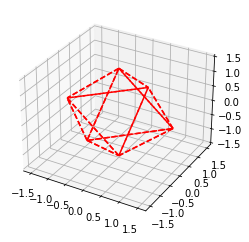

In [146]:
z_fig = plt.figure()
ax = z_fig.add_subplot(projection='3d')

if make_plot:     
    for face in BZ1_faces:
        for edge in face['Edges']:

            t = np.linspace(0,1,num=2)

            x = edge[0][0] + t*(edge[1][0] - edge[0][0])
            y = edge[0][1] + t*(edge[1][1] - edge[0][1])
            z = edge[0][2] + t*(edge[1][2] - edge[0][2])

            ax.plot(x,y,z,'r--') 

In [142]:
zone + ii

3

In [66]:
b2

array([ 1., -1.,  1.])

In [67]:
b3

array([ 1.,  1., -1.])

In [49]:
np.dot(p2-p1,K)

118.4352528130723